In [1]:
import torch
import torch.nn as nn
from torch import tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

from Ratio import *
import pycop
from pycop import simulation


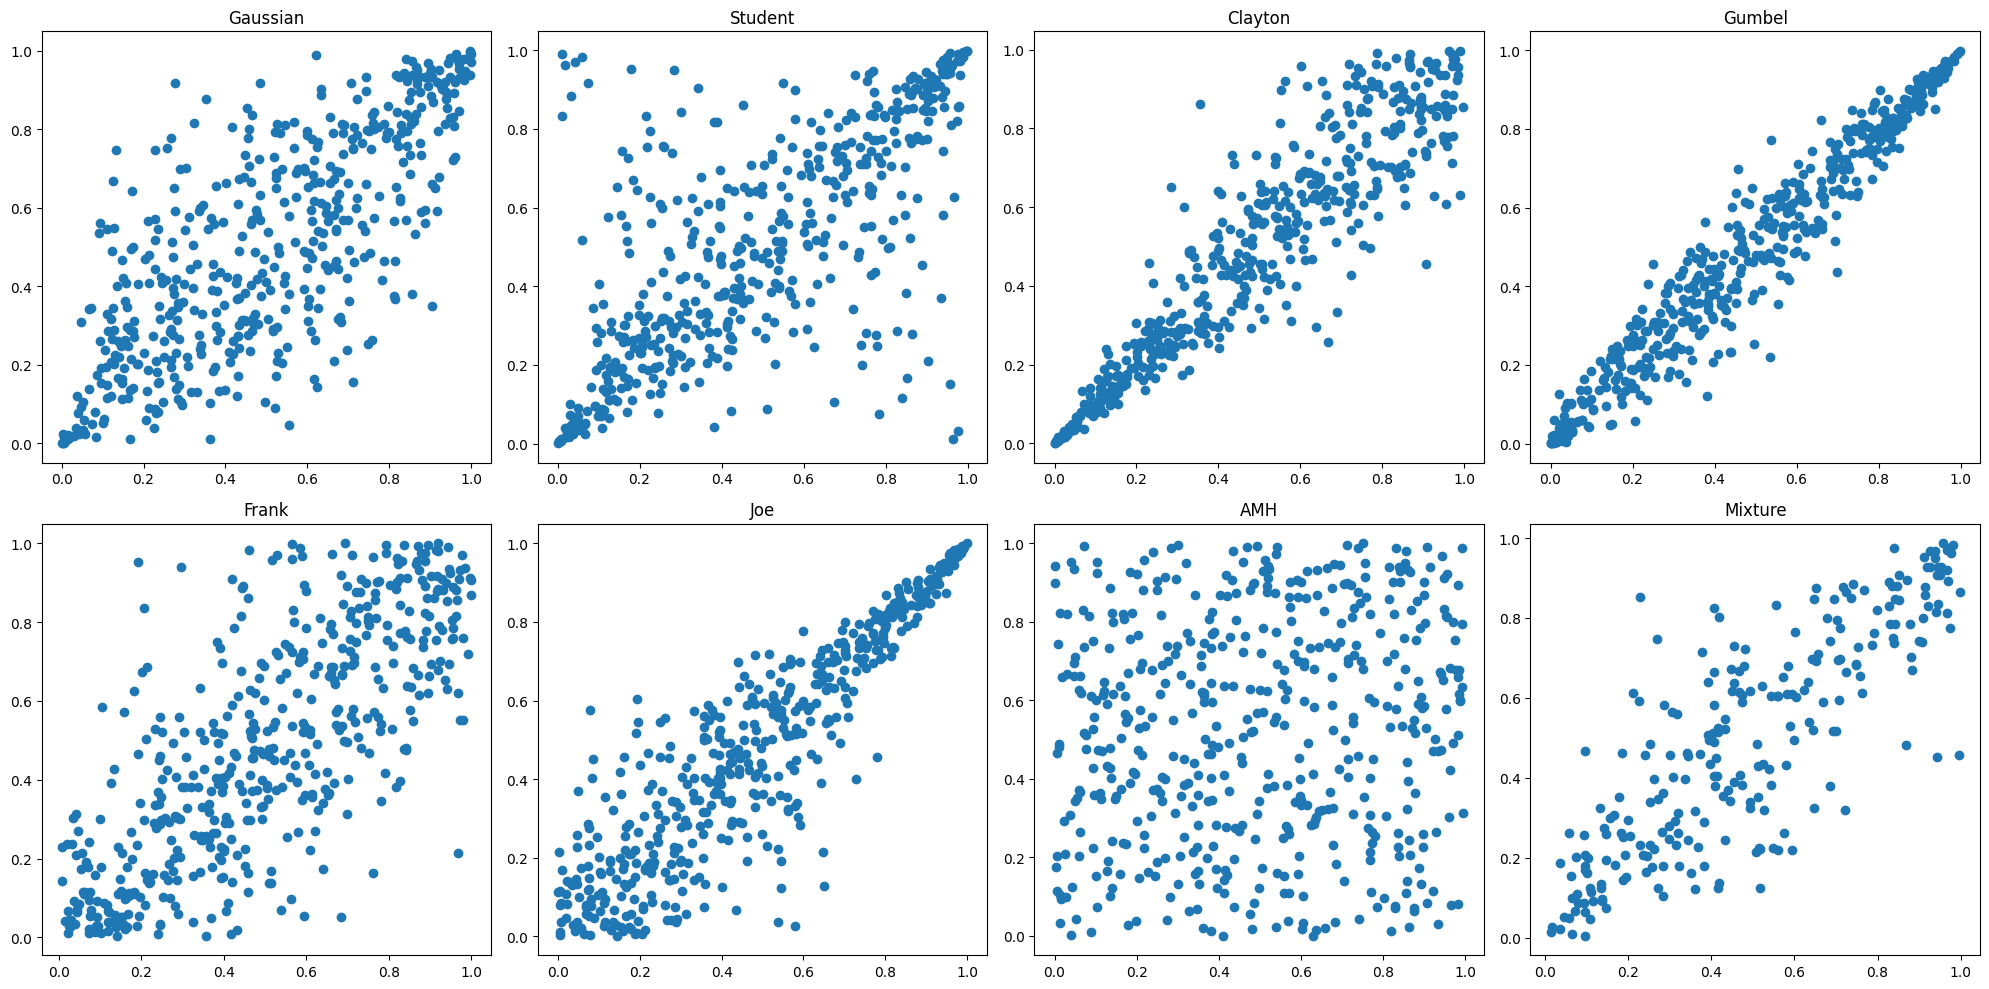

In [46]:
n = 2 # dimension
m = 500 # sample size

corrMatrix = np.array([[1, 0.8], [0.8, 1]])

u1_gaussian, u2_gaussian = simulation.simu_gaussian(n, m, corrMatrix)
u1_student, u2_student = simulation.simu_tstudent(n, m, corrMatrix, nu=1)
u_1_clayton, u_2_clayton = simulation.simu_archimedean("clayton", n, m, theta=7)
u1_gumbel, u2_gumbel = simulation.simu_archimedean("gumbel", n, m, theta=7)
u_1frank, u_2frank = simulation.simu_archimedean("frank", n, m, theta=7)
u1joe, u2joe = simulation.simu_archimedean("joe", n, m, theta=7)
u1amh, u2amh = simulation.simu_archimedean("amh", n, m, theta=0.1)


'''
u1galambos, u2galambos = simulation.simu_archimedean("galambos", n, m, theta=3)
u1fgm, u2fgm = simulation.simu_archimedean("fgm", n, m, theta=3)
u1plackett, u2plackett = simulation.simu_archimedean("plackett", n, m, theta=3)
u1rgumbel, u2rgumbel = simulation.simu_archimedean("rgumbel", n, m, theta=3)
u1rclayton, u2rclayton = simulation.simu_archimedean("rclayton", n, m, theta=3)
u1rjoe, u2rjoe = simulation.simu_archimedean("rjoe", n, m, theta=3)
u1rgalambos, u2rgalambos = simulation.simu_archimedean("rgalambos", n, m, theta=3)
u1BB1, u2BB1 = simulation.simu_BB1('BB1', n, m, theta=3)
u1BB2, u2BB2 = simulation.simu_BB2('BB2', n, m, theta=3)
'''
n = 2
m = 250

combination = [
    {"type": "clayton", "weight": 1/3, "theta": 3},
    {"type": "gumbel", "weight": 1/3, "theta": 3}
]

u1_mix, u2_mix = simulation.simu_mixture(n, m, combination)

data_u1_u2 = [(u1_gaussian,u2_gaussian), (u1_student,u2_student), (u_1_clayton,u_2_clayton), (u1_gumbel,u2_gumbel), (u_1frank,u_2frank), (u1joe,u2joe), (u1amh,u2amh), (u1_mix,u2_mix)]

# Adjusting the subplot layout to 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjusted to 2 rows and 4 columns

# First row
axs[0, 0].scatter(u1_gaussian, u2_gaussian)
axs[0, 0].set_title('Gaussian')
axs[0, 1].scatter(u1_student, u2_student)
axs[0, 1].set_title('Student')
axs[0, 2].scatter(u_1_clayton, u_2_clayton)
axs[0, 2].set_title('Clayton')
axs[0, 3].scatter(u1_gumbel, u2_gumbel)  # Moved to first row, fourth column
axs[0, 3].set_title('Gumbel')

# Second row
axs[1, 0].scatter(u_1frank, u_2frank)
axs[1, 0].set_title('Frank')
axs[1, 1].scatter(u1joe, u2joe)
axs[1, 1].set_title('Joe')
axs[1, 2].scatter(u1amh, u2amh)
axs[1, 2].set_title('AMH')
axs[1, 3].scatter(u1_mix, u2_mix)  # Moved to second row, fourth column
axs[1, 3].set_title('Mixture')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [47]:
# train ratio copula
ratios = []



for i in tqdm(range(len(data_u1_u2))):
    u1, u2 = data_u1_u2[i]
    z1, z2 = scipy.stats.norm.ppf(u1), scipy.stats.norm.ppf(u2)
    p_data = np.column_stack((z1, z2))
    p_data = np.nan_to_num(p_data, nan=0, posinf=0, neginf=0)
    q_data = np.random.randn(50000,2)
    ratio = Ratio(h_dim=100, in_dim=2, h_layers=2)

    optimizer = torch.optim.Adam(ratio.parameters(), lr= 0.002)

        
    for epoch in (range(200)):
        optimizer.zero_grad()
        r_p = ratio(tt(p_data).float())
        r_q = ratio(tt(np.random.randn(1000,2)).float())
        #loss = (-(r_p /(1+r_p)).log() - (1/(1+r_q)).log() ).mean()
        loss = loss_nce(r_p, r_q, p_data.shape[0], q_data.shape[0])
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            with torch.no_grad():
                print(f'Epoch {epoch}, loss {loss.item()}')

    ratios.append(ratio)
        

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0, loss 5.694016456604004
Epoch 100, loss 5.08493709564209


 12%|█▎        | 1/8 [00:01<00:07,  1.06s/it]

Epoch 0, loss 5.668667316436768
Epoch 100, loss 4.969562530517578


 25%|██▌       | 2/8 [00:02<00:06,  1.00s/it]

Epoch 0, loss 5.736994743347168
Epoch 100, loss 4.402365207672119


 38%|███▊      | 3/8 [00:03<00:05,  1.03s/it]

Epoch 0, loss 5.597874164581299
Epoch 100, loss 4.151627540588379


 50%|█████     | 4/8 [00:04<00:03,  1.00it/s]

Epoch 0, loss 5.679668426513672
Epoch 100, loss 5.215892791748047


 62%|██████▎   | 5/8 [00:05<00:02,  1.01it/s]

Epoch 0, loss 5.920691967010498
Epoch 100, loss 4.580757141113281


 75%|███████▌  | 6/8 [00:05<00:01,  1.01it/s]

Epoch 0, loss 5.754502773284912
Epoch 100, loss 5.578502178192139


 88%|████████▊ | 7/8 [00:06<00:00,  1.01it/s]

Epoch 0, loss 6.329867362976074
Epoch 100, loss 5.665126800537109


100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


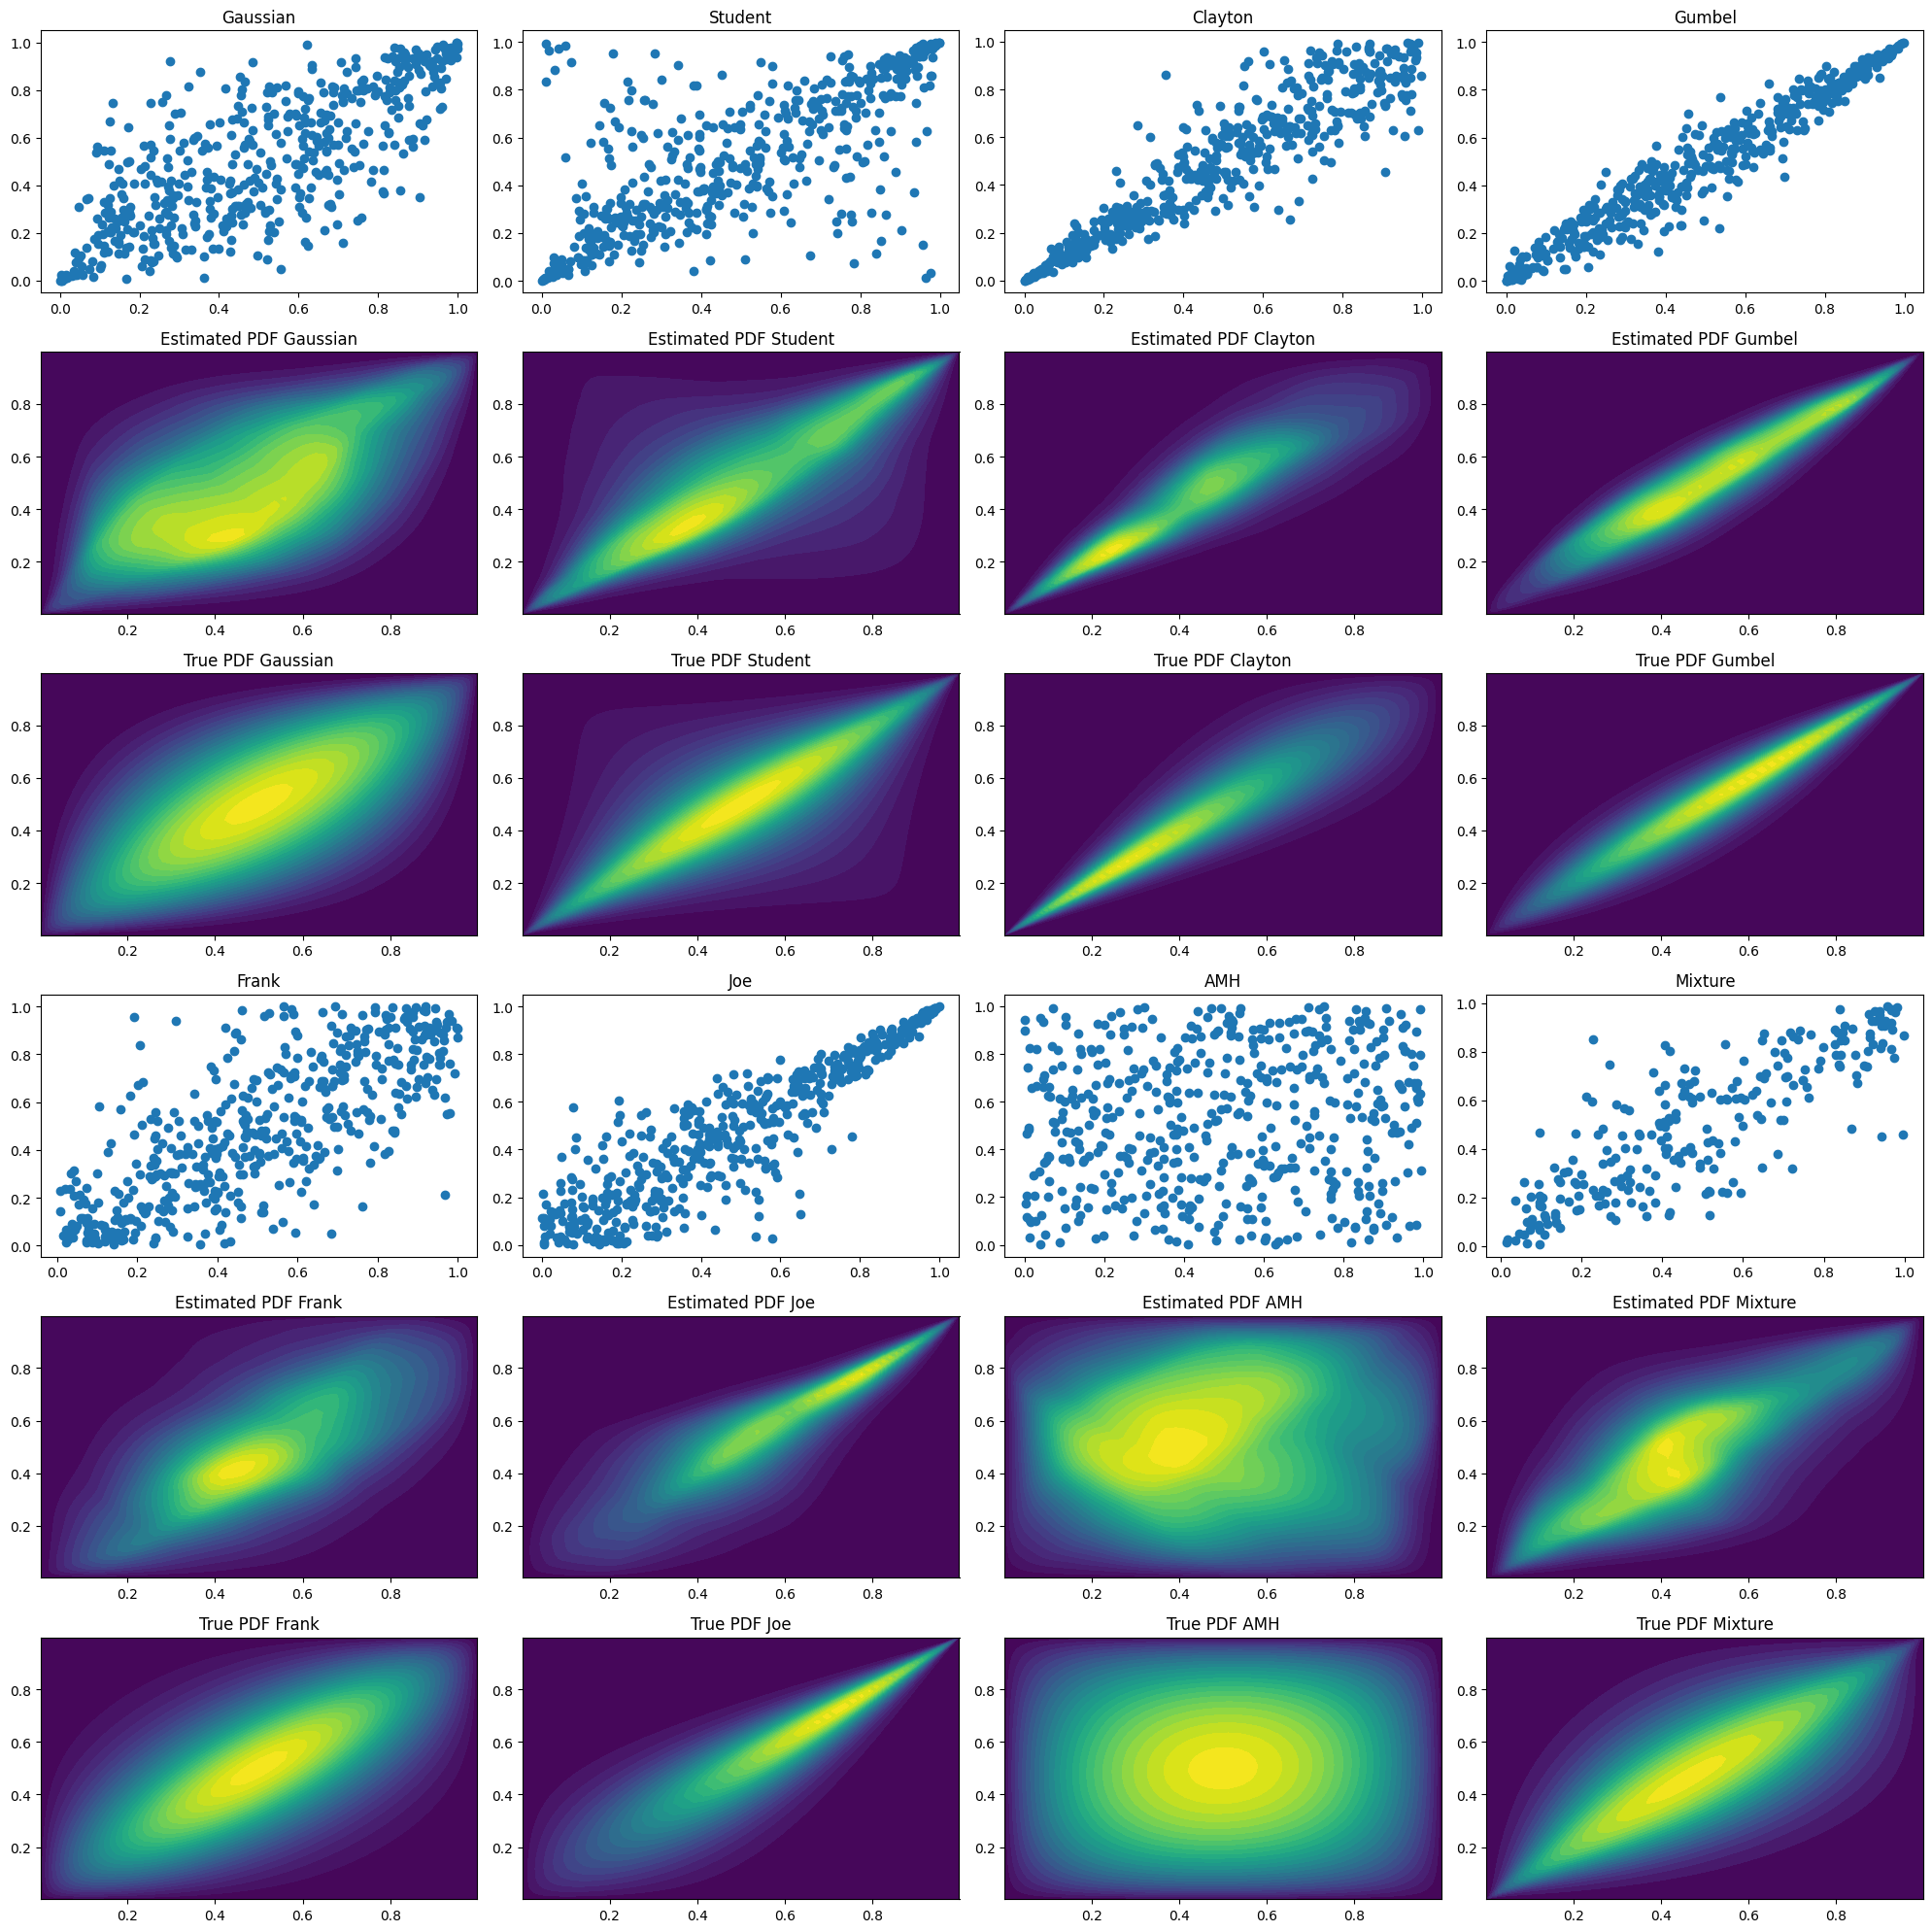

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.stats
import pycop

# Assuming the variables for scatter plots (u1_gaussian, u2_gaussian, etc.) are defined elsewhere

# Create a 4x4 subplot grid
fig, axs = plt.subplots(6, 4, figsize=(20, 20))

# First and third rows - Scatter plots
# Gaussian
axs[0, 0].scatter(u1_gaussian, u2_gaussian)
axs[0, 0].set_title('Gaussian')
# Student
axs[0, 1].scatter(u1_student, u2_student)
axs[0, 1].set_title('Student')
# Clayton
axs[0, 2].scatter(u_1_clayton, u_2_clayton)
axs[0, 2].set_title('Clayton')
# Gumbel
axs[0, 3].scatter(u1_gumbel, u2_gumbel)
axs[0, 3].set_title('Gumbel')

# Frank
axs[3, 0].scatter(u_1frank, u_2frank)
axs[3, 0].set_title('Frank')
# Joe
axs[3, 1].scatter(u1joe, u2joe)
axs[3, 1].set_title('Joe')
# AMH
axs[3, 2].scatter(u1amh, u2amh)
axs[3, 2].set_title('AMH')
# Mixture
axs[3, 3].scatter(u1_mix, u2_mix)
axs[3, 3].set_title('Mixture')

# Second and fourth rows - Contour plots
x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

# Titles for the estimated and true PDF plots
titles_estimated = ['Estimated PDF Gaussian', 'Estimated PDF Student', 'Estimated PDF Clayton', 'Estimated PDF Gumbel']
titles_true = ['True PDF Gaussian', 'True PDF Student', 'True PDF Clayton', 'True PDF Gumbel']

for i in range(4):
    r = ratios[i](z.float()).detach().numpy()  # Adjust index as needed
    Z = r.reshape(100, 100) * gauss
    axs[1, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
    axs[1, i].set_title(titles_estimated[i])

cop_row2 = [pycop.gaussian(), pycop.student(), pycop.archimedean(family="clayton"), pycop.archimedean(family="gumbel")]
cop_row2_params = [[0.8],[0.8,1],[ 7], [7]]
for i in range(4):
    r = [cop_row2[i].get_pdf(scipy.stats.norm.cdf(z[k_,0].numpy()), scipy.stats.norm.cdf(z[k_,1].numpy()),cop_row2_params[i]) for k_ in range(len(z))]
    Z = np.array(r).reshape(100, 100) * gauss   
    axs[2, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
    axs[2, i].set_title(titles_true[i])

titles_estimated_2 = ['Estimated PDF Frank', 'Estimated PDF Joe', 'Estimated PDF AMH', 'Estimated PDF Mixture']
titles_true_2 = ['True PDF Frank', 'True PDF Joe', 'True PDF AMH', 'True PDF Mixture']

for i in range(4, 8):
    r = ratios[i](z.float()).detach().numpy()  
    Z = r.reshape(100, 100) * gauss
    axs[4, i-4].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
    axs[4, i-4].set_title(titles_estimated_2[i-4])

cop_row4 = [pycop.archimedean(family="frank"), pycop.archimedean(family='joe'), pycop.archimedean(family="fgm"), pycop.mixture(['clayton','gumbel'])]
cop_row4_params = [[7],[7],[ 0.1], [0.5,3,3]]
for i in range(4):
    r = [cop_row4[i].get_pdf(scipy.stats.norm.cdf(z[k_,0].numpy()), scipy.stats.norm.cdf(z[k_,1].numpy()),cop_row4_params[i]) for k_ in range(len(z))]
    Z = np.array(r).reshape(100, 100) * gauss  
    axs[5, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
    axs[5, i].set_title(titles_true_2[i])

plt.tight_layout()
plt.show()

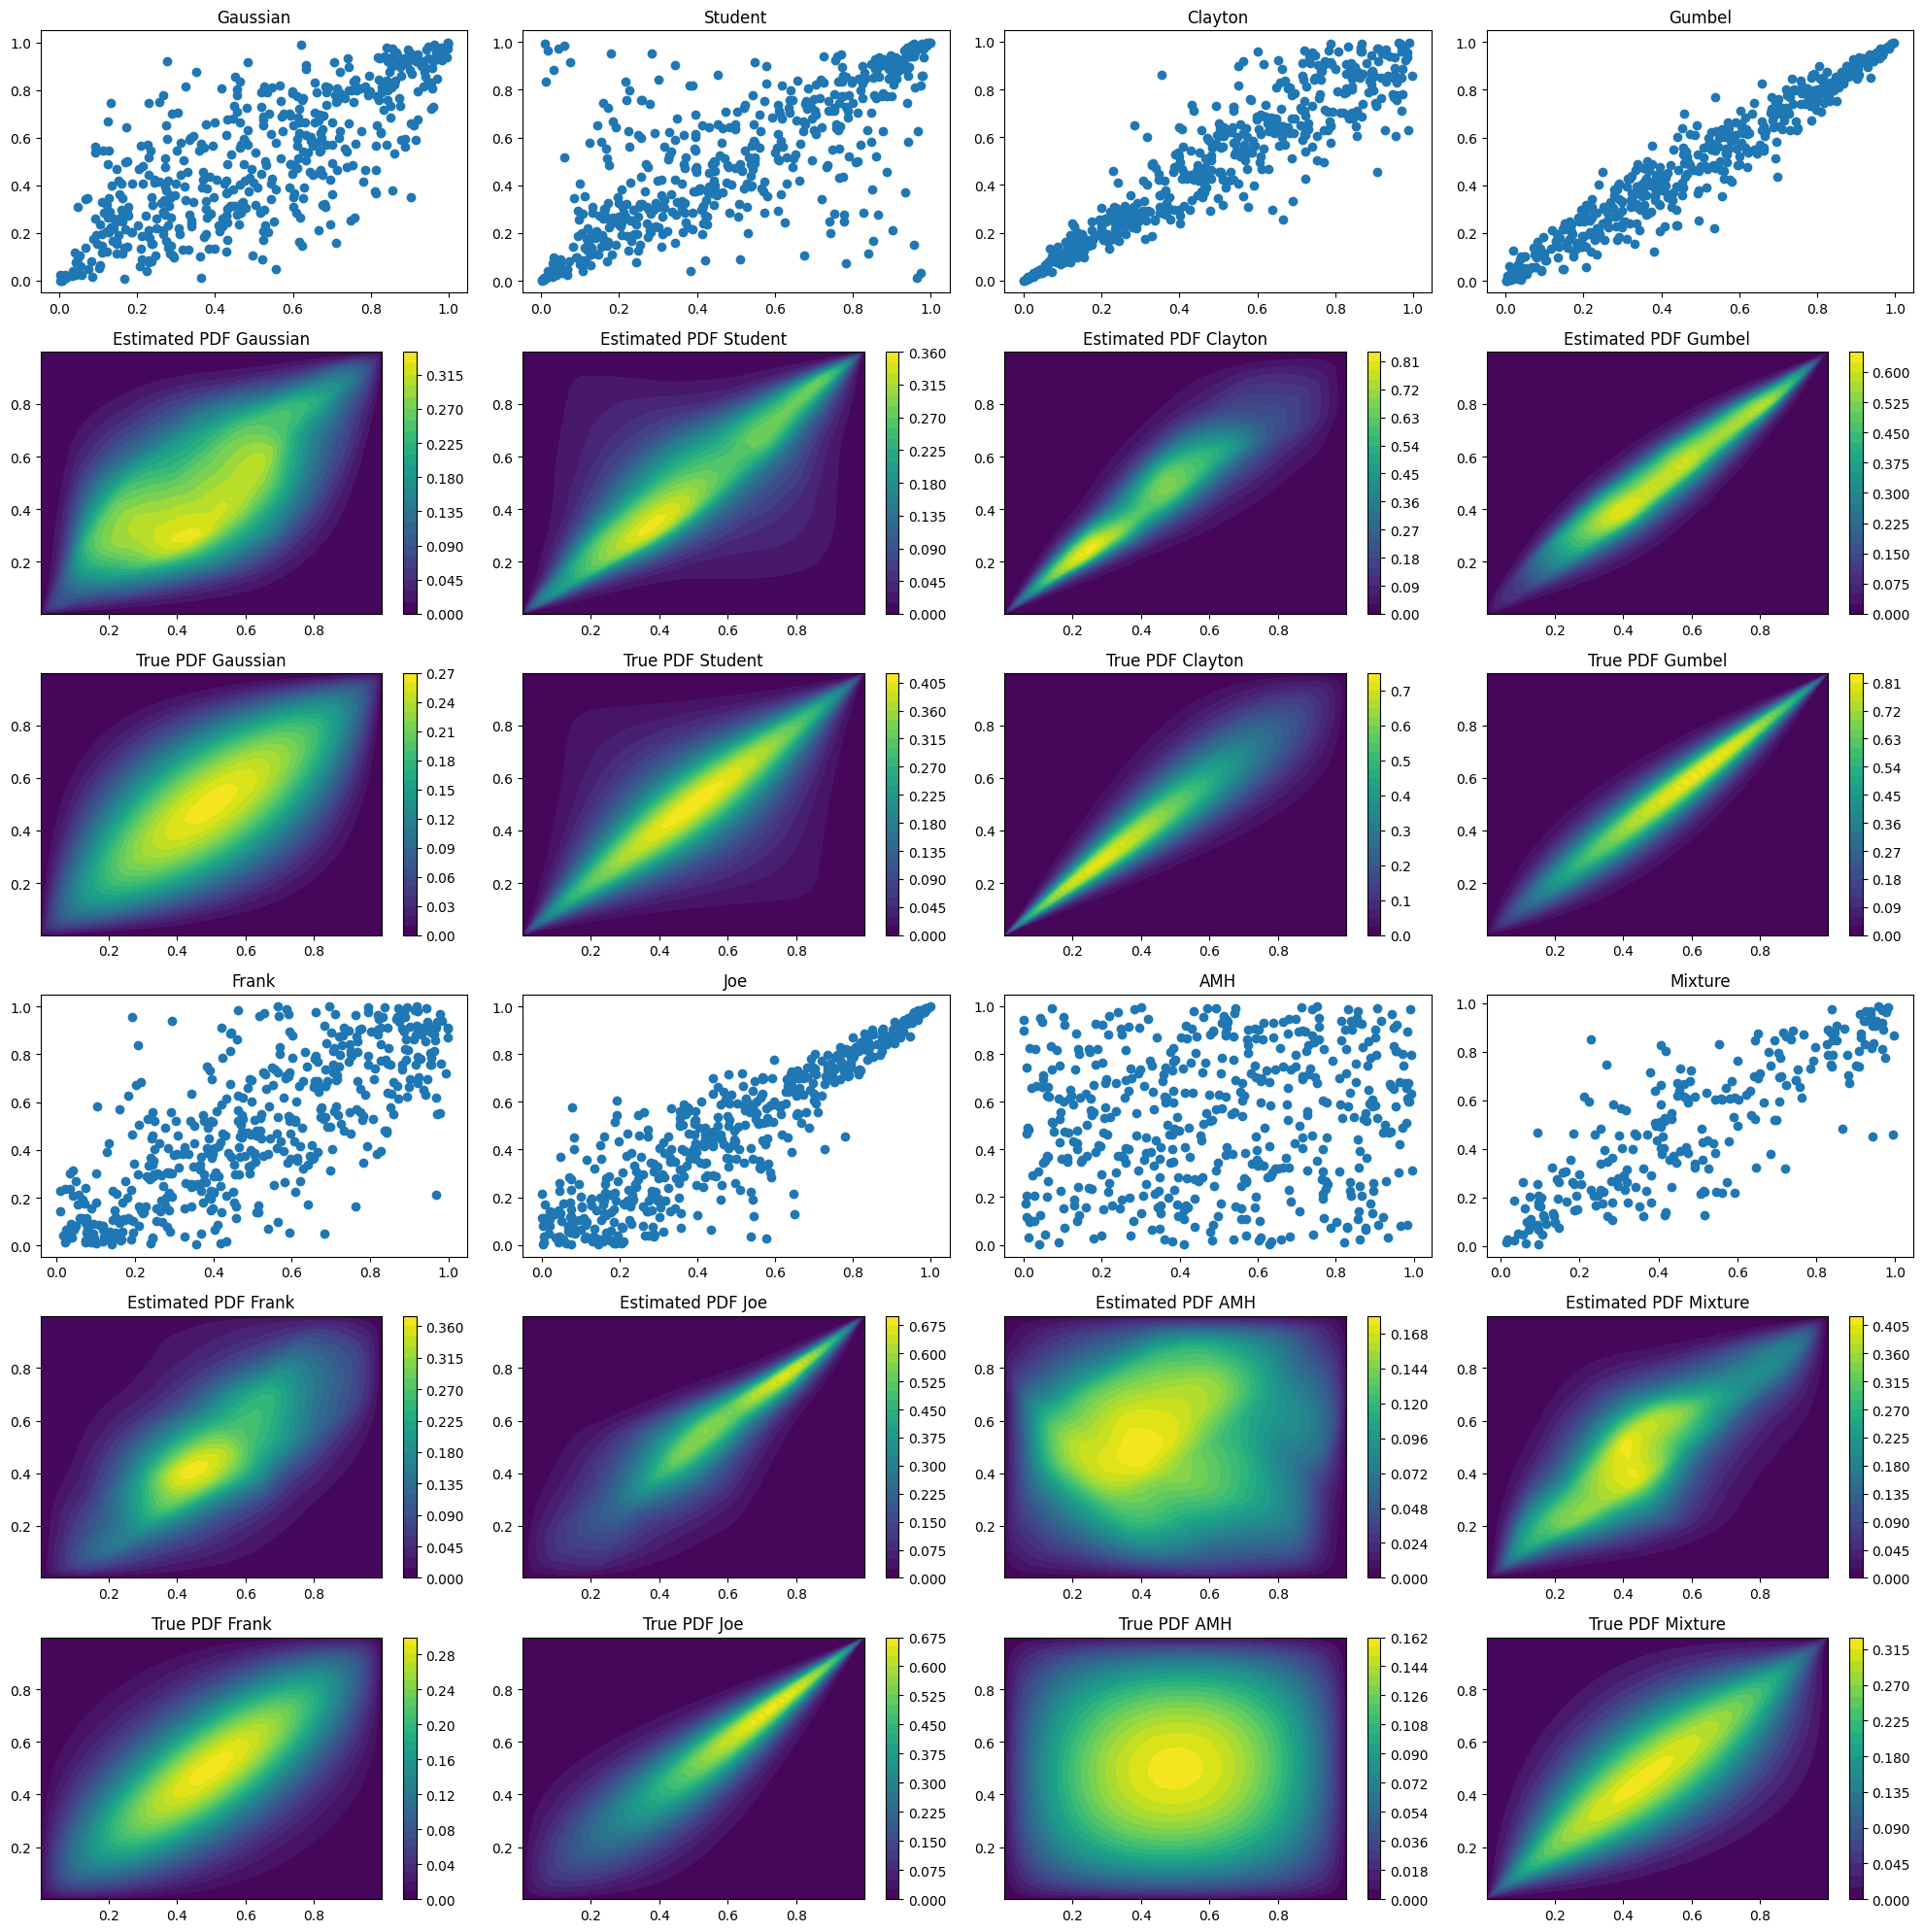

In [49]:
# Modify the contour plot sections to include colorbars
fig, axs = plt.subplots(6, 4, figsize=(20, 20))

# First and third rows - Scatter plots
# Gaussian
axs[0, 0].scatter(u1_gaussian, u2_gaussian)
axs[0, 0].set_title('Gaussian')
# Student
axs[0, 1].scatter(u1_student, u2_student)
axs[0, 1].set_title('Student')
# Clayton
axs[0, 2].scatter(u_1_clayton, u_2_clayton)
axs[0, 2].set_title('Clayton')
# Gumbel
axs[0, 3].scatter(u1_gumbel, u2_gumbel)
axs[0, 3].set_title('Gumbel')

# Frank
axs[3, 0].scatter(u_1frank, u_2frank)
axs[3, 0].set_title('Frank')
# Joe
axs[3, 1].scatter(u1joe, u2joe)
axs[3, 1].set_title('Joe')
# AMH
axs[3, 2].scatter(u1amh, u2amh)
axs[3, 2].set_title('AMH')
# Mixture
axs[3, 3].scatter(u1_mix, u2_mix)
axs[3, 3].set_title('Mixture')

# Second and fourth rows - Contour plots
x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

# Titles for the estimated and true PDF plots
titles_estimated = ['Estimated PDF Gaussian', 'Estimated PDF Student', 'Estimated PDF Clayton', 'Estimated PDF Gumbel']
titles_true = ['True PDF Gaussian', 'True PDF Student', 'True PDF Clayton', 'True PDF Gumbel']


for i in range(4):
    r = ratios[i](z.float()).detach().numpy()  # Adjust index as needed
    Z = r.reshape(100, 100) * gauss
    contour = axs[1, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
    fig.colorbar(contour, ax=axs[1, i])
    axs[1, i].set_title(titles_estimated[i])

for i in range(4):
    r = [cop_row2[i].get_pdf(scipy.stats.norm.cdf(z[k_,0].numpy()), scipy.stats.norm.cdf(z[k_,1].numpy()),cop_row2_params[i]) for k_ in range(len(z))]
    Z = np.array(r).reshape(100, 100) * gauss   
    contour = axs[2, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
    fig.colorbar(contour, ax=axs[2, i])
    axs[2, i].set_title(titles_true[i])

for i in range(4, 8):
    r = ratios[i](z.float()).detach().numpy()  
    Z = r.reshape(100, 100) * gauss
    contour = axs[4, i-4].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
    fig.colorbar(contour, ax=axs[4, i-4])
    axs[4, i-4].set_title(titles_estimated_2[i-4])

for i in range(4):
    r = [cop_row4[i].get_pdf(scipy.stats.norm.cdf(z[k_,0].numpy()), scipy.stats.norm.cdf(z[k_,1].numpy()),cop_row4_params[i]) for k_ in range(len(z))]
    Z = np.array(r).reshape(100, 100) * gauss  
    contour = axs[5, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=30)
    fig.colorbar(contour, ax=axs[5, i])
    axs[5, i].set_title(titles_true_2[i])

plt.tight_layout()
plt.show()

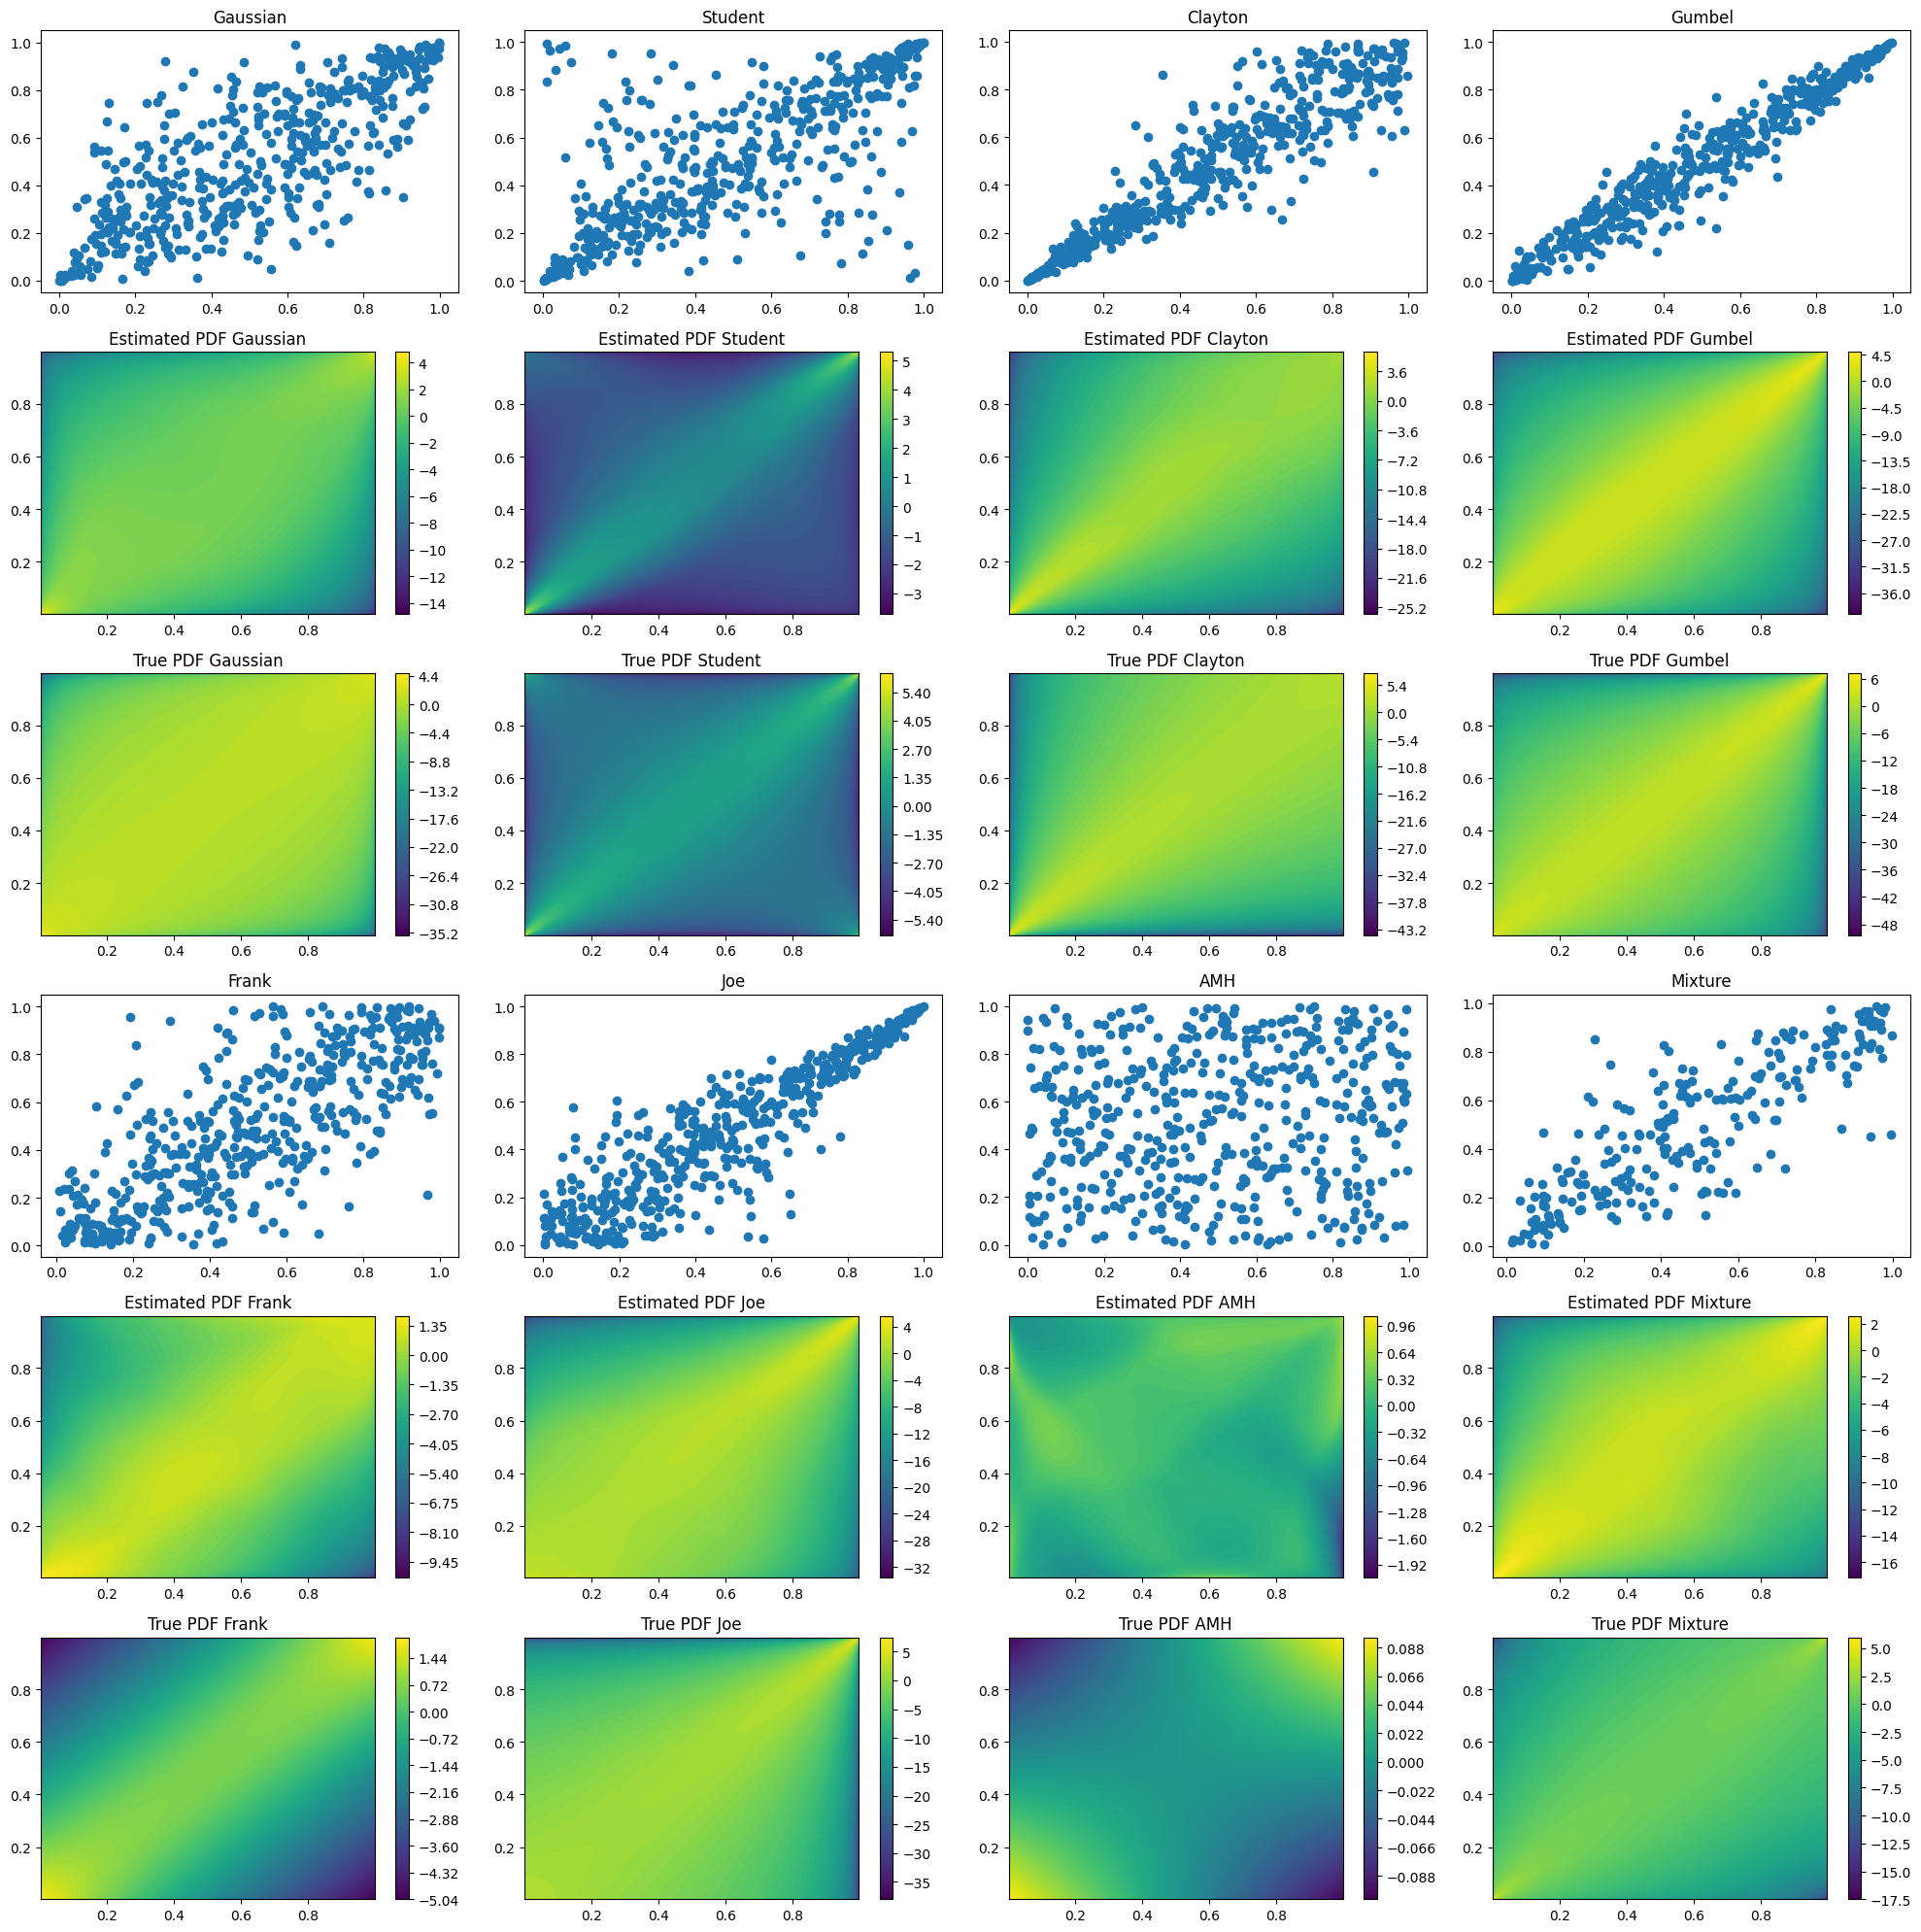

In [50]:
# Modify the contour plot sections to include colorbars
fig, axs = plt.subplots(6, 4, figsize=(20, 20))

# First and third rows - Scatter plots
# Gaussian
axs[0, 0].scatter(u1_gaussian, u2_gaussian)
axs[0, 0].set_title('Gaussian')
# Student
axs[0, 1].scatter(u1_student, u2_student)
axs[0, 1].set_title('Student')
# Clayton
axs[0, 2].scatter(u_1_clayton, u_2_clayton)
axs[0, 2].set_title('Clayton')
# Gumbel
axs[0, 3].scatter(u1_gumbel, u2_gumbel)
axs[0, 3].set_title('Gumbel')

# Frank
axs[3, 0].scatter(u_1frank, u_2frank)
axs[3, 0].set_title('Frank')
# Joe
axs[3, 1].scatter(u1joe, u2joe)
axs[3, 1].set_title('Joe')
# AMH
axs[3, 2].scatter(u1amh, u2amh)
axs[3, 2].set_title('AMH')
# Mixture
axs[3, 3].scatter(u1_mix, u2_mix)
axs[3, 3].set_title('Mixture')

# Second and fourth rows - Contour plots
x, y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
z = torch.tensor(np.column_stack((x.flatten(), y.flatten())))
gauss = scipy.stats.norm.pdf(x) * scipy.stats.norm.pdf(y)

# Titles for the estimated and true PDF plots
titles_estimated = ['Estimated PDF Gaussian', 'Estimated PDF Student', 'Estimated PDF Clayton', 'Estimated PDF Gumbel']
titles_true = ['True PDF Gaussian', 'True PDF Student', 'True PDF Clayton', 'True PDF Gumbel']

lvl=100

for i in range(4):
    r = ratios[i](z.float()).detach().numpy()  # Adjust index as needed
    Z = np.log(r.reshape(100, 100)) #* gauss
    contour = axs[1, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=lvl)
    fig.colorbar(contour, ax=axs[1, i])
    axs[1, i].set_title(titles_estimated[i])

for i in range(4):
    r = [cop_row2[i].get_pdf(scipy.stats.norm.cdf(z[k_,0].numpy()), scipy.stats.norm.cdf(z[k_,1].numpy()),cop_row2_params[i]) for k_ in range(len(z))]
    Z = np.log(np.array(r)).reshape(100, 100) #* gauss   
    contour = axs[2, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=lvl)
    fig.colorbar(contour, ax=axs[2, i])
    axs[2, i].set_title(titles_true[i])

for i in range(4, 8):
    r = ratios[i](z.float()).detach().numpy()  
    Z = np.log(r.reshape(100, 100)) #* gauss
    contour = axs[4, i-4].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=lvl)
    fig.colorbar(contour, ax=axs[4, i-4])
    axs[4, i-4].set_title(titles_estimated_2[i-4])

for i in range(4):
    r = [cop_row4[i].get_pdf(scipy.stats.norm.cdf(z[k_,0].numpy()), scipy.stats.norm.cdf(z[k_,1].numpy()),cop_row4_params[i]) for k_ in range(len(z))]
    Z = np.log(np.array(r)).reshape(100, 100) #* gauss  
    contour = axs[5, i].contourf(scipy.stats.norm.cdf(x), scipy.stats.norm.cdf(y), Z, levels=lvl)
    fig.colorbar(contour, ax=axs[5, i])
    axs[5, i].set_title(titles_true_2[i])

plt.tight_layout()
plt.show()